# CSC_52081_EP_TP2

## Introduction

File may be found in: [https://www.lix.polytechnique.fr/~jread](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/).

### Main Objects

Intelligent decision making involves several components. In the context of a low-dimensional and synthetic toy:

- **perception**: observation;
- **knowledge**: representation;
- **reasoning**: inference;
- **acting**: decision-making;

The objective is to design a rational / intelligent agent with:
- *learning*;
- *scalability*;

### Imports

Make sure the `environment.py` is in your working directory.

In [1]:
from environment import Environment
from extracter import extract_tagged_cells

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


extract_tagged_cells(
    "CSC_52081_EP_TP1.ipynb",
    "agent.py",
    tags=["import numpy as np", "def generate_trajectory", "class Agent"]
)

from agent import Agent, generate_trajectory

['import numpy as np', 'def generate_trajectory', 'class Agent']
Extracted 3 cells with tags '['import numpy as np', 'def generate_trajectory', 'class Agent']' to agent.py


## Environment

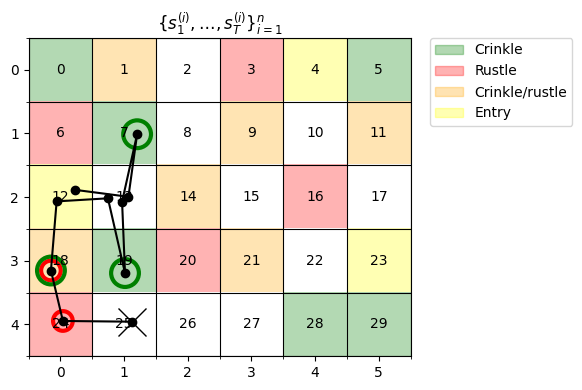

In [2]:
# grid position colors
#   1: crinkle
#   2: rustle
#   3: crinkle and rustle
#   4: entry

grid: np.ndarray[float] = np.array([
    [1, 3, 0, 2, 4, 1],
    [2, 1, 0, 3, 0, 3],
    [4, 0, 3, 0, 2, 0],
    [3, 1, 2, 3, 0, 4],
    [2, 0, 0, 0, 1, 1]
])

env: Environment = Environment(grid)
observations, states = generate_trajectory(env, 10)

fig, ax = env.render(states, observations, title=r"$\{s^{(i)}_1,\ldots,s^{(i)}_T\}_{i=1}^n$")
plt.show()


## Part I. `agent.P_trajectories(M>0)`

### Theory

In that case, the probability tree was easy to enumerate, but this time we have modified the `Environment` class in `environment.py` to produce a more dense tree by allowing false-positive sound emissions.

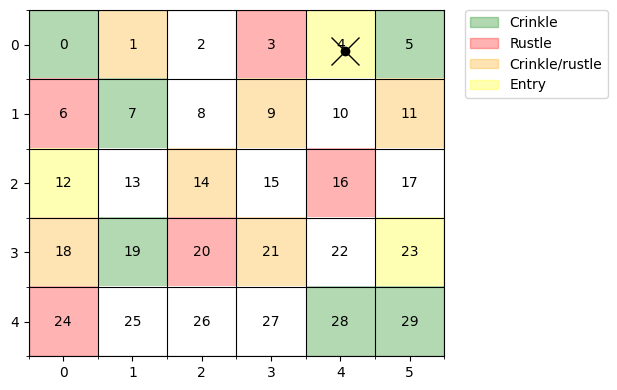

In [3]:
env = Environment(grid, fps=True)   # False Positives

states, observations = env.step()
states = np.array([states]).reshape(1,-1)
observations = np.array([observations])

fig, ax = env.render(states, observations)
plt.show()

#### Monte Carlo Search

Essentially, you should sample `M` trajectories as an approximation:
$$
    \{s^{(m)}_1,\ldots,s^{(m)}_T, p^{(m)}\}_{m=1}^M \approx P(S_1,\ldots,S_T \mid \vec{x}_1,\ldots,\vec{x}_T)
$$

You can use what is known as **ancestral sampling**, since you have access to the environment, sample $s_1 \sim P(s_1 | \vec{x}_1)$, then $s_2 \sim P(s_2 | s_1)$ and so on.

Again, this is not the same as simply using `generate_trajectory()`, because we are conditioning on the observation $\vec{x}_1,\ldots,\vec{x}_T$. 

### Question

Reimplement `agent.P_trajectories` where it should use your solution from last week when `M<0` and take `M` samples when `M>0`.

What happens if we only made a longer trajectory, but it was still sparse in probabilities? Would *ancestral sampling* still be appropriate?

### Answer

With longer trajectories it would be more likely for the Monte Carlo Search using Ancestral Sampling to consider trajectories not suited for the problem lending to an overall worse estimation of the agent's action.

In this case, Ancestral Sampling would not be a suited method for the problem.

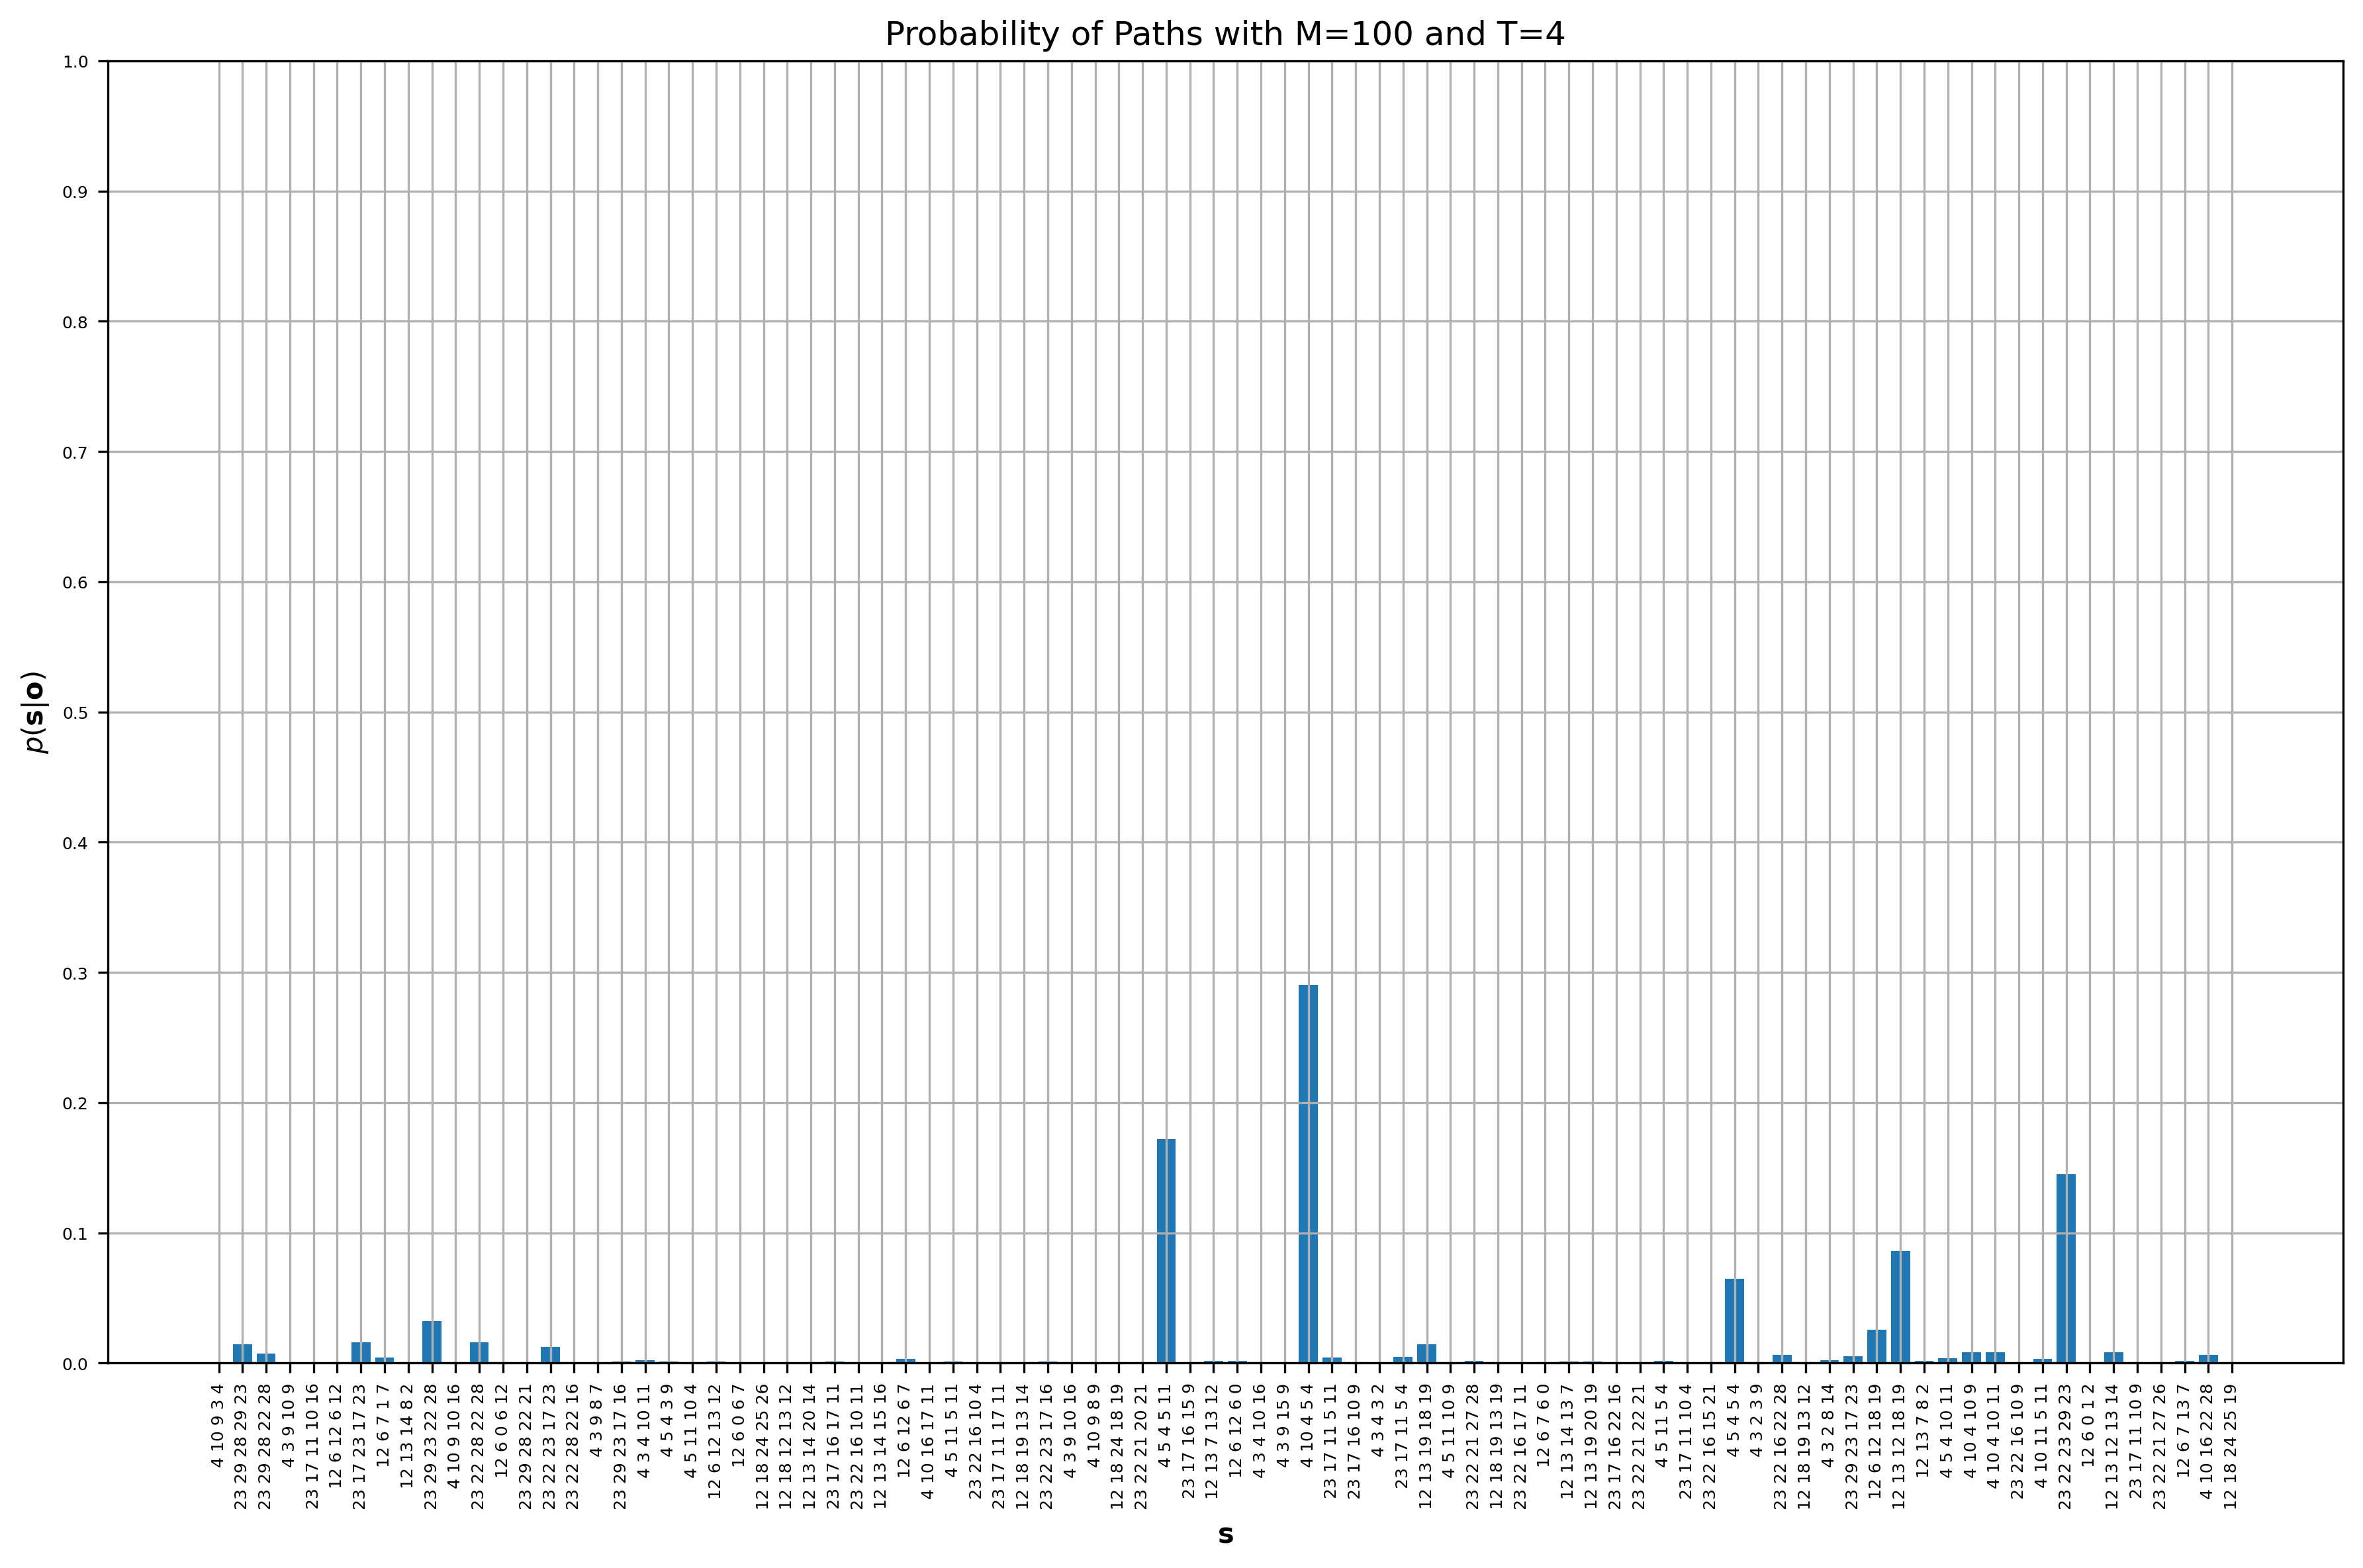

In [4]:
trajectory_length = 4
monte_calor_constant = 100

agent = Agent(env)
observations, states = generate_trajectory(env, trajectory_length)

P_trajectories = agent.P_trajectories(observations, M=monte_calor_constant)

plt.figure(figsize=(12, 8), dpi=300)
plt.bar(list(P_trajectories.keys()), list(P_trajectories.values()))
plt.title(f"Probability of Paths with M={monte_calor_constant} and T={trajectory_length}")
plt.xlabel(r"$\mathbf{s}$")
plt.xticks(rotation=90, ha='center')
plt.ylabel(r"$p(\mathbf{s}|\mathbf{o})$")
plt.ylim([0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.tick_params(labelsize=6)
plt.tight_layout()
plt.show()

## Part II. `torch.nn.TinyTransformerDecoder`

Until now we supposed full unfettered access to the environment. But now suppose that we do *not* have access to the environment definition. Rather, we need to learn it.

In [5]:
env = Environment(grid, fps=False)

### Theory

Suppose that we *do* have access to trajectories from the environment, generated by some agent:
$$
    \mathbf{o}_1,\ldots,\mathbf{o}_T \sim p
    \qquad\text{and}\qquad
    \mathbf{a} \sim \pi(\mathbf{o}_1,\ldots,\mathbf{o}_T)
$$

Where $\mathbf{a}$ is a one-hot-encoded action, relating to the number of possible actions.

#### Generating Data

First, it is necessary to generate a dataset to be used in the machine learning model:
$$
    D_{i\in[0,\;n]} = \{(\mathbf{o}_{1:T}, \mathbf{a}_i)\}
$$

Where the dataset $D$ will contain $n$ tuples, each containing $T\times 2$ sound observations and $T\times \text{n\_states}$ actions.

In [6]:
def create_dataset(N: int = 1000, T: int = 6) -> list[float]:
    '''
    Return a dataset D containing N tuples of T observations and respective actions.

    Parameters
    ----------

        N (int, optional): number of examples on the dataset. Default is '1000'.
        T (int, optional): number of observations per example. Default is '6'.
    '''
    D = []

    for _ in range(N):
        observations, states = generate_trajectory(env, T)
        observations = torch.tensor(observations, dtype = torch.float)
        states = torch.tensor(states)

        one_hot = torch.nn.functional.one_hot(states, num_classes=env.n_states)
        D.append((observations, one_hot.float()))

    return D

D = create_dataset()

#### Transformers

We will be using transformers, which are excellent for sequential modelling. Have a look at the following `class`, which we will use in the following. 

In [7]:
class TinyTransformerDecoder(nn.Module):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            embedding_dim: int = 16,
            num_layers: int = 1,
            num_heads: int = 1,
            max_seq_len: int = 500
        ):
        super(TinyTransformerDecoder, self).__init__()

        self.input_projection = nn.Linear(input_dim, embedding_dim)

        self.positional_encoding = self._generate_positional_encoding(
            max_seq_len, embedding_dim
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embedding_dim,
            nhead = num_heads,
            dim_feedforward = 2 * embedding_dim,
            dropout = 0.0,
            batch_first = True  # main modification
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.output_projection = nn.Linear(embedding_dim, output_dim)


    def _generate_positional_encoding(self, max_seq_len: int, embedding_dim: int) -> torch.Tensor:
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim)
        )
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        return pos_encoding  # Shape: (max_seq_len, embedding_dim)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)

        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))

        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)

        output = self.output_projection(x_transformed)
        return output

## Part III. Imitation Learning

### Theory

Imitation learning is an alternative to reinforcement learning, for producing an autonomous agent. Rather than learn via reinforcement, we can learn to imitate an expert agent that has already solved a given task.

In this case, we would suppose that the agent which has generated the trajectories in data set `D` is such an expert. Specifically, in imitation learning:
$$
    \mathbf{a}_t = \pi(\mathbf{o}_1, \ldots, \mathbf{o}_t)
$$

Where $\pi$ the policy of the agent, that maps inputs to an action.

#### Questions

Use the `TinyTransformerDecoder` defined above to complete the Imitation Learning task in the cell below.

**Important** Do not remove the first comment from the cell `# TASK 2 IMITATION LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

In the case of the Environment studied in Lab 01, is it clear why we should consider the full history of observations?

#### Answer

In [8]:
# TASK 2 IMITATION LEARNING

from torch.utils.data import DataLoader, TensorDataset


D = create_dataset(N = 50000)

# Split dataset into 80% training and 20% validation
train_size = int(0.8 * len(D))
val_size = len(D) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(D, [train_size, val_size])

# Convert dataset to tensors
observations = torch.stack([obs for obs, _ in train_dataset])  # Shape: (N, T, input_dim)
one_hot_states = torch.stack([states for _, states in train_dataset])  # Shape: (N, T, num_classes)





# Create DataLoader
dataset = TensorDataset(observations, one_hot_states)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
model = TinyTransformerDecoder(
    input_dim=observations.size(-1),
    output_dim=one_hot_states.size(-1),
    embedding_dim=16,
    num_layers=1,
    num_heads=1,
    max_seq_len=observations.size(1)
)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

# Training loop
for epoch in range(10):  # Number of epochs
    for obs_batch, target_batch in dataloader:
        # Forward pass
        predictions = model(obs_batch)  # Shape: (batch_size, seq_len, num_classes)

        # Reshape for CrossEntropyLoss (requires class indices, not one-hot)
        target_batch = target_batch.argmax(dim=-1)  # Shape: (batch_size, seq_len)

        # Compute loss
        loss = criterion(predictions.view(-1, predictions.size(-1)), target_batch.view(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")




# Convert dataset to tensors
observations = torch.stack([obs for obs, _ in val_dataset])  # Shape: (N, T, input_dim)
one_hot_states = torch.stack([states for _, states in val_dataset])  # Shape: (N, T, num_classes)

# Create DataLoader
dataset = TensorDataset(observations, one_hot_states)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for obs_batch, target_batch in dataloader:
        predictions = model(obs_batch)
        predicted_classes = predictions.argmax(dim=-1)  # Get class indices
        target_classes = target_batch.argmax(dim=-1)  # Convert one-hot to indices

        total_correct += (predicted_classes == target_classes).sum().item()
        total_samples += target_classes.numel()

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


/home/trofino/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1, Loss: 1.4140886068344116
Epoch 2, Loss: 1.4528865814208984
Epoch 3, Loss: 1.5811100006103516
Epoch 4, Loss: 1.3556517362594604
Epoch 5, Loss: 1.389198660850525
Epoch 6, Loss: 1.3020895719528198
Epoch 7, Loss: 1.274779200553894
Epoch 8, Loss: 1.4900709390640259
Epoch 9, Loss: 1.3050562143325806
Epoch 10, Loss: 1.2390207052230835
Validation Accuracy: 42.84%


### Evaluation

#### Question

How well is our model (agent) performing (the one learned via imitation learning)?

In the following, we deploy the agent and test it, in a similar way to Lab 01 (on the same environment). 

First, we wrap the model inference in the `act` function of an Agent class (namely, `DTAgent` below), so we can compare. 

#### Answer

Complete the `act` function in the `DTAgent` class below to return an integer indicating the action, as per the description of the scenario given already in Lab 01. 

Hint: to get probabilities, use `torch.softmax(outputs, axis = 2)`

In [9]:
class DTAgent:

    def act(self,observation):
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

        ooo : array_like(int,ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        a : int
            the chosen action a, it should be one of the n_states
        '''

        # Predict

        single_observation = torch.tensor(observation, dtype=torch.float)  # Shape: (seq_len, input_dim)

        # Add a batch dimension (1, seq_len, input_dim)
        single_observation = single_observation.unsqueeze(0)

        # Pass the observation through the model
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for inference
            logits = model(single_observation)  # Shape: (1, seq_len, output_dim)

        # Apply softmax to the logits to get probabilities
        probabilities = torch.softmax(logits, dim=-1)  # Shape: (1, seq_len, output_dim)

        # If you want probabilities for the last timestep
        last_timestep_probs = probabilities[:, -1, :]  # Shape: (1, output_dim)

        # Optionally, get the predicted class
        predicted_class = last_timestep_probs.argmax(dim=-1)  # Shape: (1,)

        return int(predicted_class)

In the following, we perform the evaluation. 

In [10]:
# Instantiate the agent
dt_agent = DTAgent()
n_test = 1000
T_test = 6
score = 0

# Generate some trajectories from the environment 
n_test=1000
for i in range(n_test): 
    oooo, ssss = generate_trajectory(env,T_test)
    oooo = torch.tensor(oooo, dtype = torch.float32)
    a_t = dt_agent.act(oooo)
    score += env.rwd(a_t,ssss[-1])
score = score/n_test
print(score)

/tmp/ipykernel_65791/1111941556.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single_observation = torch.tensor(observation, dtype=torch.float)  # Shape: (seq_len, input_dim)


0.43


## Part IV. Model Learning

### Theory

Imitation Learning in the real world can be a bit risky. If we had a *model* of the environment, we could 'practice'. Namely, we seek
$$
    \mathbf{x}_{t+1} \sim P(\mathbf{x}_{t+1} | \mathbf{x}_1, \ldots, \mathbf{x}_t)
$$ 

With this we could generate trajectories, with which to safely train an agent in simulation. 

#### Question

Use the `TinyTransformerDecoder` to complete the Model Learning task in the cell below. Again, do not replace or remove the `TASK` tag.

Then, complete the `sample_next_obs` function of the `DTEnvironment` class to sample 

**Important** Do not remove the first comment from the cell `# TASK 3 MODEL LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

#### Answer

In [12]:
# TASK 3 MODEL LEARNING


input_dim = 2
output_dim = 2
embedding_dim = 16
num_layers = 1
num_heads = 1
seq_length = 6
batch_size = 16



import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset
class ObservationDataset(Dataset):
    def __init__(self, trajectories, seq_len):
        self.trajectories = trajectories
        self.seq_len = seq_len

    def __len__(self):
        return len(self.trajectories) - self.seq_len

    def __getitem__(self, idx):
        x = self.trajectories[idx:idx+self.seq_len]
        y = self.trajectories[idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Generate some dummy data for demonstration
def generate_dummy_data(num_trajectories, T):
    trajectories = []
    for _ in range(num_trajectories):
        o, _ = generate_trajectory(env, T)
        trajectories.extend(o)
    return np.array(trajectories)

# Hyperparameters
input_dim = 2
output_dim = 2
embedding_dim = 16
num_layers = 1
num_heads = 1
max_seq_len = 10
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Generate data
# env = env  # Your environment
trajectories = generate_dummy_data(num_trajectories=100, T=50)
dataset = ObservationDataset(trajectories, seq_len=max_seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = TinyTransformerDecoder(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    max_seq_len=max_seq_len
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(x)
        # Compute loss
        loss = criterion(y_pred[:, -1, :], y)  # Predict the next observation
        # Backward pass
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    x, y = dataset[0]  # Example input
    y_pred = model(x.unsqueeze(0))
    print("Predicted:", y_pred[:, -1, :])
    print("Actual:", y)



Epoch 1/10, Loss: 0.21924357116222382
Epoch 2/10, Loss: 0.17774291336536407
Epoch 3/10, Loss: 0.20501013100147247
Epoch 4/10, Loss: 0.1857304573059082
Epoch 5/10, Loss: 0.1397451013326645
Epoch 6/10, Loss: 0.22537516057491302
Epoch 7/10, Loss: 0.2393452376127243
Epoch 8/10, Loss: 0.16533294320106506
Epoch 9/10, Loss: 0.2194242775440216
Epoch 10/10, Loss: 0.19097685813903809
Predicted: tensor([[0.3534, 0.3856]])
Actual: tensor([1., 1.])


In [13]:
class DTEnvironment:

    def sample_next_obs(self,ooo):
        '''
        Provide a next observation, to follow the provided observation. 

        Parameters
        ----------

        ooo : array_like(ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        o : array_like(ndim=1)
            the next observation as an array of 2 ints
        '''

        input_tensor = torch.tensor(ooo, dtype=torch.float32)

        model.eval()
        with torch.no_grad():  # Disable gradient comp for inference
            obs = model(input_tensor.unsqueeze(0))
        obs = torch.sigmoid(obs)

        # Extract the next observation
        final_obs = obs[:, -1, :]
        
        return torch.bernoulli(final_obs).int().numpy()

Once we have a model of the environment, we can simulate new trajectories, as exemplified as follows. 

In [20]:
dt_env = DTEnvironment()
# Generate some trajectories from the environment 
T=10
oooo = np.zeros((T,2))
for t in range(1,T):
    oooo[t,:] = dt_env.sample_next_obs(oooo[0:t,:])

print(oooo)

[[0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


You can use your `p_traj` function to check the 'legitimacy' of these trajectories (they should have probability greater than 0). 

Of course, in a real-world environment, validating the trajectories is more subjective, or requires human expertise.

0.9999999999999992


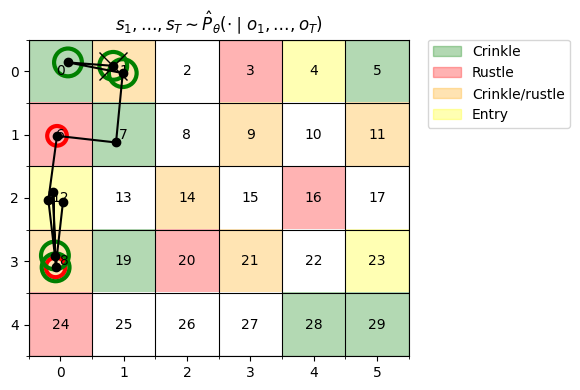

In [21]:
agent = Agent(env)
P_joint = agent.P_trajectories(oooo.astype(int))

# Check should sum to 1 (or close enough)
probs = list(P_joint.values())
print(sum(probs))
assert abs(sum(probs) - 1) <= 0.05

# Extract possible paths
paths = [np.fromstring(k, sep=' ') for k in P_joint.keys()] 

# Take some samples
sample_indices = np.random.choice(len(probs), size=10, p=probs)
trajs = [paths[i].astype(int) for i in sample_indices]

# Visualise 
fig, ax = env.render(trajs[0], oooo, title=r"$s_1,\ldots,s_T \sim \hat P_\theta(\cdot \mid o_1,\ldots,o_T)$")
plt.show()

## Part V. Shared Representation

### Theory

Notice that both the previous tasks (imitation learning and model learning) have something in common; namely the input. It suggests it may be more efficient to share a representation in a deep architecture, rather than reimplementing both as separate networks. Such architectures will also be very useful later for reinforcement learning. 

Have a look at the architecture defined in the following. 

In [23]:
class TinyTransformerDecoderDoubleHead(nn.Module):
    def __init__(self, input_dim, act_dim, obs_dim, embedding_dim=16, num_layers=1, num_heads=1, max_seq_len=500):
        super(TinyTransformerDecoderDoubleHead, self).__init__()
        
        self.input_projection = nn.Linear(input_dim, embedding_dim)
        
        # Positional encoding
        self.positional_encoding = self._generate_positional_encoding(max_seq_len, embedding_dim)
        
        # Use TransformerEncoder with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * 2,
            dropout=0.,  # small model/dataset
            batch_first=True  # This is the key change
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.act_projection = nn.Linear(embedding_dim, act_dim)
        self.obs_projection = nn.Linear(embedding_dim, obs_dim)
        
    def _generate_positional_encoding(self, max_seq_len, embedding_dim):
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding  # Shape: (max_seq_len, embedding_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)
        
        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))
        
        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)
        
        act = self.act_projection(x_transformed)
        obs = self.obs_projection(x_transformed)
        return act, obs

In [24]:
input_dim = 2
act_dim = 30
obs_dim = 2
embedding_dim = 16
num_layers = 1
num_heads = 1
seq_length = 6
batch_size = 16

#### Question

Implement the Architecture in PyTorch using a double head (and shared inner representations). 

#### Answer

In [27]:
# TASK 4 SHARED REPRESENTATION 
model_shared = TinyTransformerDecoderDoubleHead(input_dim, act_dim, obs_dim, embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads)
dataloader = torch.utils.data.DataLoader(D, batch_size=batch_size, shuffle=True)


import torch
from torch.utils.data import Dataset, DataLoader

class TrajectoryDataset(Dataset):
    def __init__(self, env, num_trajectories=1000, seq_length=5):
        self.data = [generate_trajectory(env, seq_length) for _ in range(num_trajectories)]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        o, s = self.data[idx]  # (seq_length, 2) and (seq_length,)

        # Inputs: observation history (excluding last one)
        x = o[:-1]  # Shape: (seq_length - 1, 2)

        # Targets: predict next observation and state
        o_target = o[1:]  # Shape: (seq_length - 1, 2)
        s_target = s[1:]  # Shape: (seq_length - 1,)

        return torch.tensor(x, dtype=torch.float32), \
               torch.tensor(o_target, dtype=torch.float32), \
               torch.tensor(s_target, dtype=torch.long)

# Example usage
dataset = TrajectoryDataset(env, num_trajectories=5000, seq_length=5)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model = TinyTransformerDecoderDoubleHead(input_dim=2, act_dim=2, obs_dim=30).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, epochs=50):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for x, o_target, s_target in dataloader:
            x, o_target, s_target = x.to(device), o_target.to(device), s_target.to(device)
            
            optimizer.zero_grad()
            
            o_pred, s_pred = model(x)

            # Compute losses
            loss_obs = F.mse_loss(o_pred, o_target)  # MSE for observation prediction
            loss_state = F.cross_entropy(s_pred.view(-1, 30), s_target.view(-1))  # Cross-Entropy for state classification
            
            loss = loss_obs + loss_state  # Total loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Train the model
train(model, dataloader, epochs=50)

Epoch 1/50, Loss: 3.6758
Epoch 2/50, Loss: 3.2588
Epoch 3/50, Loss: 2.9086
Epoch 4/50, Loss: 2.5520
Epoch 5/50, Loss: 2.4988
Epoch 6/50, Loss: 2.4711
Epoch 7/50, Loss: 2.4516
Epoch 8/50, Loss: 2.4318
Epoch 9/50, Loss: 2.4154
Epoch 10/50, Loss: 2.3997
Epoch 11/50, Loss: 2.3876
Epoch 12/50, Loss: 2.3734
Epoch 13/50, Loss: 2.3630
Epoch 14/50, Loss: 2.3521
Epoch 15/50, Loss: 2.3482
Epoch 16/50, Loss: 2.3398
Epoch 17/50, Loss: 2.3346
Epoch 18/50, Loss: 2.3314
Epoch 19/50, Loss: 2.3323
Epoch 20/50, Loss: 2.3212
Epoch 21/50, Loss: 2.3207
Epoch 22/50, Loss: 2.3171
Epoch 23/50, Loss: 2.3157
Epoch 24/50, Loss: 2.3105
Epoch 25/50, Loss: 2.3075
Epoch 26/50, Loss: 2.3082
Epoch 27/50, Loss: 2.3040
Epoch 28/50, Loss: 2.3040
Epoch 29/50, Loss: 2.3008
Epoch 30/50, Loss: 2.3004
Epoch 31/50, Loss: 2.3004
Epoch 32/50, Loss: 2.2991
Epoch 33/50, Loss: 2.2978
Epoch 34/50, Loss: 2.2965
Epoch 35/50, Loss: 2.2973
Epoch 36/50, Loss: 2.2945
Epoch 37/50, Loss: 2.2929
Epoch 38/50, Loss: 2.2916
Epoch 39/50, Loss: 2.

In [28]:
def test(model, env, seq_length=5):
    model.eval()
    
    with torch.no_grad():
        o, s = generate_trajectory(env, seq_length)
        x = torch.tensor(o[:-1], dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
        
        o_pred, s_pred = model(x)
        
        o_pred = o_pred.squeeze(0).cpu().numpy()  # Remove batch dimension
        s_pred = s_pred.argmax(dim=-1).squeeze(0).cpu().numpy()  # Get most probable state

        print("True Observations:", o[1:])
        print("Predicted Observations:", o_pred.round())  # Round predictions
        print("True States:", s[1:])
        print("Predicted States:", s_pred)

# Run test
test(model, env)

True Observations: [[0 0]
 [1 0]
 [0 0]
 [1 0]]
Predicted Observations: [[ 0.  0.]
 [ 1.  0.]
 [-0.  0.]
 [ 1.  0.]]
True States: [22 16 15 14]
Predicted States: [10 16 15 16]
